In [58]:
import numpy as np
import scipy
from numpy import linalg as LA

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Задача XIV.10.2
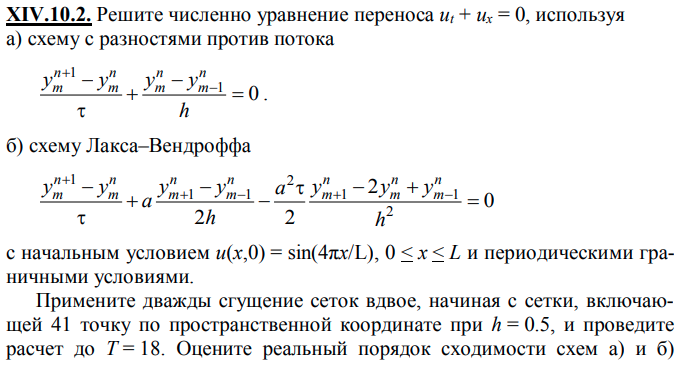

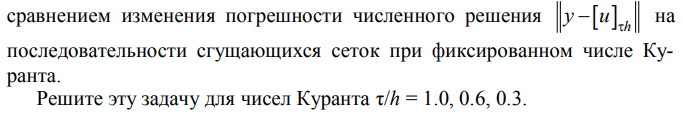

In [59]:
L = 20

T = 100
cfl = np.array([0.6, 1, 1.01])
# при cfl == 1 ошибка = 0

T_output = [5, 10, 15, 18, 40, 50, 70, 100]

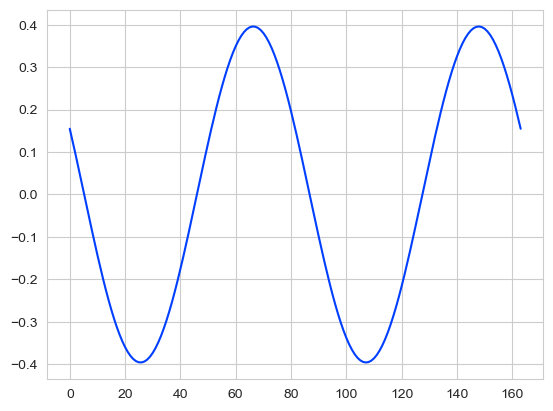

0.620 


Шагов по пространству 164


In [60]:
# уголок

f = lambda cf, y_nm, y_n_m1: y_nm * (1 - cf) + cf * y_n_m1
f_gran  = lambda x_m: np.sin(4 * np.pi * x_m/L)
f_chisl = lambda x_m, cur_t : np.sin(4 * np.pi * (x_m - cur_t)/L)

def solve(g, f_gran, num, clear = False, cur_cfl = cfl[0]):

    x = np.linspace(0, L, num)
    h = x[-1] - x[-2]
    cur_tau = cur_cfl * h

    t_out = 0
    mistake = []
    res = []

    for cur_t in np.arange(0, T, cur_tau):
        t_out += 1

        teor = f_chisl(x, cur_t)
        if cur_t == 0:
            y_cur = f_gran(x)
            res.append(y_cur)

        else:
            y_cur = []
            
            if g == f:
                for i in range(1, len(x)):
                    y_cur.append(g(cur_cfl, res[-1][i], res[-1][i-1]))
                y_cur.insert(0, y_cur[-1])


            else:
                for i in range(1, len(x)-1):
                    y_cur.append(g(cur_cfl, res[-1][i], res[-1][i-1], res[-1][i+1]))

                y_cur.append(g(cur_cfl, res[-1][len(x)-2], res[-1][len(x)-1], res[-1][0]))
                y_cur.insert(0, g(cur_cfl, res[-1][len(x)-1], res[-1][0], res[-1][1]))

            y_cur = np.array(y_cur)
            res.append(y_cur)
            mistake.append(np.abs(teor - y_cur))

        if t_out % 100 == 0:
            if clear:
                clear_output(clear)
            plt.style.use("seaborn-bright")
            plt.plot(res[-1])
            plt.show()

    print('{:.3f}'.format(np.max(mistake)), '\n\n')
    return res, np.max(mistake)


error_ugol = []
for num in 41*np.arange(1,5):
    res, er = solve(f, f_gran, num, True)
    print(f'Шагов по пространству {num}')
    error_ugol.append(er) 
    time.sleep(5)

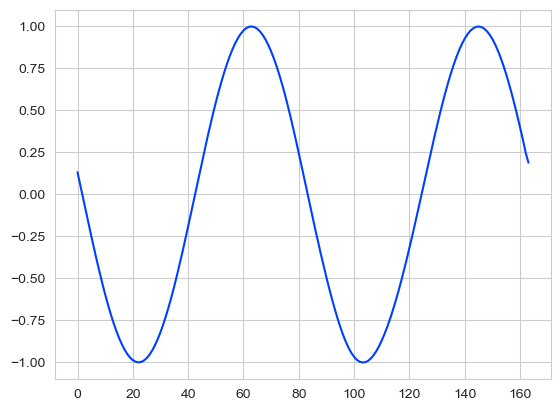

0.270 


Шагов по пространству 164


In [61]:
# LW

f_gw =  lambda cf, y_nm, y_n_m1, y_n_p1: y_nm * (1 - cf**2) + y_n_p1 * cf * (cf-1)/2 + y_n_m1 * cf * (cf+1)/2


error_lw = []
for num in 41 * np.arange(1,5):
    res, er = solve(f_gw, f_gran, num, True)
    print(f'Шагов по пространству {num}')
    error_lw.append(er)
    time.sleep(5)

In [62]:
def grid_h(num):
    x = np.linspace(0, L, num)
    return x[-1] - x[-2]
grid_h_plot = [grid_h(num) for num in 41*np.arange(1,5)]

Мин. ошибка уголок: 0.620
Мин. ошибка LW: 0.270


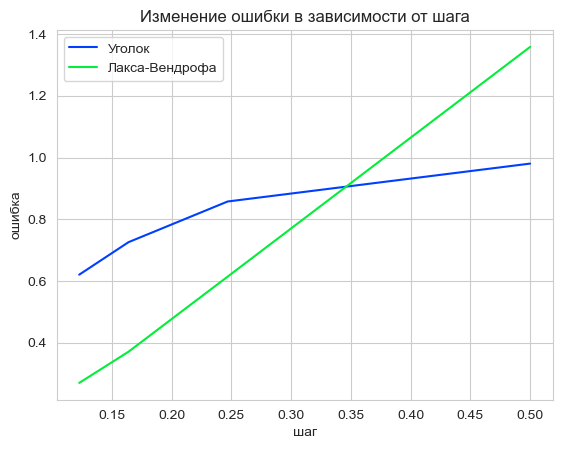

In [63]:
import pandas as pd
sns.set_style("whitegrid")
sns.lineplot(data = pd.DataFrame({'шаг': grid_h_plot, 'ошибка' : error_ugol}), x= 'шаг', y = 'ошибка', label = 'Уголок').set(title='Изменение ошибки в зависимости от шага')
sns.lineplot(data = pd.DataFrame({'шаг': grid_h_plot, 'ошибка' : error_lw}), x= 'шаг', y = 'ошибка', label = 'Лакса-Вендрофа')


print('Мин. ошибка уголок: {:.3f}'.format(np.min(error_ugol)))
print('Мин. ошибка LW: {:.3f}'.format(np.min(error_lw)))

Наклон для уголка: 0.25277
Наклон для LW: 0.79109


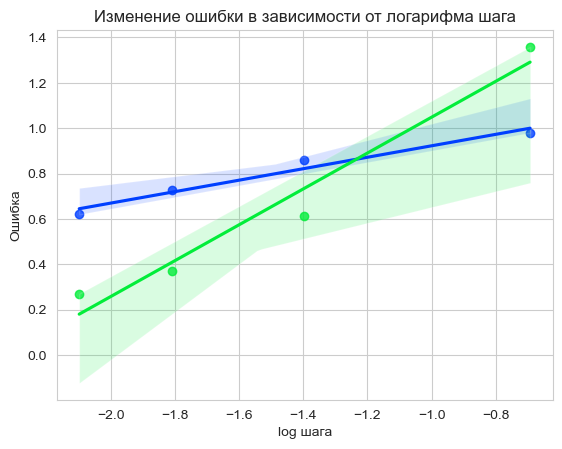

In [64]:
sns.set_style("whitegrid")
p_ugol = sns.regplot(data = pd.DataFrame({'log шагa': np.log(grid_h_plot), 'Ошибка' : error_ugol}), 
                     x= 'log шагa', y = 'Ошибка', label = 'Уголок',  order = 1).set(title='Изменение ошибки в зависимости от логарифма шага')
p_lw = sns.regplot(data = pd.DataFrame({'log шагa': np.log(grid_h_plot), 'Ошибка' : error_lw}), 
                   x= 'log шагa', y = 'Ошибка', label = 'Лакса-Вендрофа', order = 1)

slope_ugol, intercept_ugol, _,_,_ = scipy.stats.linregress(x=np.log(grid_h_plot),
                                                       y=error_ugol)

slope_lw, intercept_lw, _,_,_ = scipy.stats.linregress(x=np.log(grid_h_plot),
                                                       y=error_lw)

print("Наклон для уголка: {:.5f}".format(slope_ugol))
print("Наклон для LW: {:.5f}".format(slope_lw))

# Задача Римана о распаде разрыва

In [55]:
L = 10
T = 0.02
ns = 100
nt = 100
s = np.linspace(-L, L, ns)
t = np.linspace(0, T, nt)
tau = t[1] - t[0]
h = s[-1] - s[-2]

gamma = 5/3

u_l = 0
ro_l = 13
p_l = 1013250

u_r = 0
ro_r = 1.3
p_r = 101325

In [56]:
p_data = np.zeros((nt,ns))
u_data = np.zeros((nt,ns))
ro_data = np.zeros((nt,ns))
w_data = np.zeros((nt,3,ns))

p_cur_t = np.zeros(ns)
eps_cur_t = np.zeros(ns)
ro_cur_t = np.zeros(ns)
u_cur_t = np.zeros(ns)

# начальные данные
# предположим, что распределение u, ro, p одинаково в пределах каждой из правой и левой половин

for i in range(ns):
    p_cur_t[i] = (p_r, p_l)[i < ns/2]  # true = 1 index, false = 0
    ro_cur_t[i] = (ro_r, ro_l)[i < ns/2]
    u_cur_t[i] = (u_r, u_l)[i < ns/2]
    eps_cur_t[i] = p_cur_t[i] / ((gamma - 1) * ro_cur_t[i])

p_data[0][:] = p_cur_t
u_data[0][:] = u_cur_t
ro_data[0][:] = ro_cur_t

0.019


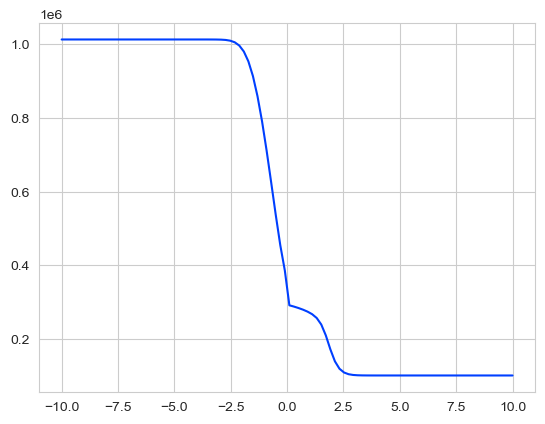

In [57]:
def a(u, eps):

    c = gamma* (gamma - 1) * eps

    omega_T = np.array([[-u*c,  c,  gamma-1],
                        [-c**2, 0,  gamma-1],
                        [u*c,   -c, gamma-1]])
    
    lambd = np.array([[u+c,   0,    0],
                      [0,     u,    0],
                      [0,     0,  u-c]])
    
    omega_T_inv = LA.inv(omega_T)

    a_normal = (omega_T_inv.dot(lambd)).dot(omega_T)
    
    a_abs = (omega_T_inv.dot(np.abs(lambd))).dot(omega_T)

    return a_normal, a_abs, lambd

def check_cfl(tau, h, lambd):
    max_lamb = np.max(np.abs(lambd))

    cfl = tau * max_lamb/h 

    if cfl <= 1:
        return tau, h
    
    else:
        while cfl > 0.01:
            tau = tau/2
            cfl = tau * max_lamb/h

        if tau < 1e-7:
            tau = 1e-7
            
        return tau, h

kir = lambda x, y, z, A, B, tau: y -(tau / (2*h)) * A.dot(z-x) + (tau / (2*h)) * B.dot(z - 2 * y + x)

ro_new_cur = np.zeros(ns)
u_new_cur = np.zeros(ns)
p_new_cur = np.zeros(ns)
eps_new_cur = np.zeros(ns)

for ind_t in range(1, nt):
    for i in range(1, ns-1):
        
        a_normal, a_abs, lambd = a(u_cur_t[i], eps_cur_t[i])

        tau, h = check_cfl(tau, h , lambd)

    ## Расчет вектора в консервативных переменных
        w0 = np.array([ro_cur_t[i-1],
                       ro_cur_t[i-1] * u_cur_t[i-1],
                       ro_cur_t[i-1] * eps_cur_t[i-1]])
        
        w1 = np.array([ro_cur_t[i],
                       ro_cur_t[i] * u_cur_t[i],
                       ro_cur_t[i] * eps_cur_t[i]])
        
        w2 = np.array([ro_cur_t[i+1],
                       ro_cur_t[i+1] * u_cur_t[i+1],
                       ro_cur_t[i+1] * eps_cur_t[i+1]])
        
        w = kir(w0, w1, w2, a_normal, a_abs, tau)

        ro_new_cur[i] = w[0]
        u_new_cur[i] = w[1] / w[0]
        eps_new_cur[i] = w[2] / w[0]
        p_new_cur[i] = (gamma - 1.0) * ro_new_cur[i] * eps_new_cur[i]     

    ro_new_cur[0] = ro_new_cur[1]
    u_new_cur[0] = u_new_cur[1]
    eps_new_cur[0] = eps_new_cur[1]
    p_new_cur[0] = p_new_cur[1]

    ro_new_cur[ns - 1] = ro_new_cur[ns - 2]
    u_new_cur[ns - 1] = u_new_cur[ns - 2]
    eps_new_cur[ns - 1] = eps_new_cur[ns - 2]
    p_new_cur[ns - 1] = p_new_cur[ns - 2]  
          
    if(ind_t % 5 == 0):
        u_data[int(ind_t/5)][:] = u_new_cur
        ro_data[int(ind_t/5)][:] = ro_new_cur
        p_data[int(ind_t/5)][:] = p_new_cur
        
        clear_output(True)
        print('{:.3f}'.format(t[ind_t]))
        plt.plot(s, p_new_cur)
        plt.show()
        time.sleep(2)

    ro_cur_t = ro_new_cur
    u_cur_t = u_new_cur
    eps_cur_t = eps_new_cur
    p_cur_t = p_new_cur
